In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import utils as ut

DATA_PATH = '../../datav2/esp/'

%load_ext autoreload
%autoreload 2

In [2]:
df = ut.load_data(DATA_PATH,'train',nclasses=5).loc[:,['review_content','review_rate']]
df.head(5)

Dataset cargado para 5 clases (muy malo=1, malo=2, medio=3, bueno=4 muy bueno=5)
Num samples per category:
1    92477
2    92449
3    92487
4    92501
5    92454
Name: review_rate, dtype: int64


,review_content,review_rate
0,"Esta de muy baja calidad, no fue lo esperado.",2
1,"Reconozco que fue muy económico, pero su durab...",2
2,Muy bien muy bien muy bien muy bien muy bien m...,5
3,No me fue útil para mí. Diseño muy bueno.,2
4,No fue lo estipulado. Solo eso voy aclarar.,1


Dataset cargado para 5 clases (muy malo=1, malo=2, medio=3, bueno=4 muy bueno=5)
Num samples per category:
1    92477
2    92449
3    92487
4    92501
5    92454
Name: review_rate, dtype: int64
hidden size: 32
Train accuracy: 47.86%
Dev accuracy: 47.33%

hidden size: 64
Train accuracy: 48.11%
Dev accuracy: 47.86%

hidden size: 128
Train accuracy: 47.97%
Dev accuracy: 47.85%



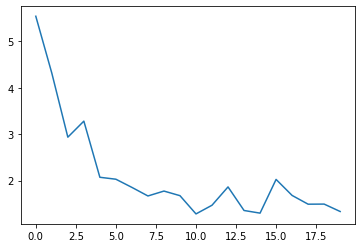

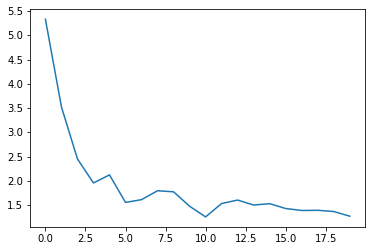

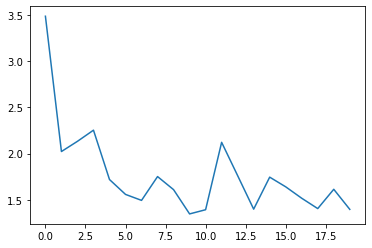

In [5]:
from hyperparams_search import normalize_dataset, SoftmaxClassifier, CatBOWVectorizer

def hidden_size_inspection():

    df = ut.load_data(DATA_PATH,'train',nclasses=5).loc[:,['review_content','review_rate']]
    #df = df.sample(frac=0.01,random_state=27381)

    df = normalize_dataset(df)
    df_train, df_dev = ut.train_dev_split(df,dev_size=0.1,random_state=2376482)
    y_train, y_dev = df_train['review_rate'].values-1, df_dev['review_rate'].values-1

    vec = CatBOWVectorizer(token_pattern=r'(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)',
                max_features=10000,labels_names=[0,1,2,3,4])
    X_train = vec.fit_transform(df_train['review_content'],y_train)
    X_dev = vec.transform(df_dev['review_content'])

    for hidden_size in [32,64,128]:

        clf = SoftmaxClassifier(hidden_size,n_iters=20,batch_size=256,
                learning_rate=1e-4,weight_decay=0.0,n_classes=5,device='cuda:1')
    
        loss_history = clf.fit(X_train,y_train)

        fig, ax = plt.subplots()
        ax.plot(loss_history)

        y_train_pred = clf.predict(X_train)
        y_dev_pred = clf.predict(X_dev)
        print('hidden size:',hidden_size)
        print('Train accuracy: {:.2f}%'.format( (y_train == y_train_pred).mean()*100 ))
        print('Dev accuracy: {:.2f}%'.format( (y_dev == y_dev_pred).mean()*100 ))
        print()

hidden_size_inspection()

Elegimos el siguiente modelo:

* 2-layer network con hidden size = 4 y CrossEntropyLoss
* Learning rate 1e-3, optimización Adam, sin weight decay, 20 iteraciones y 256 de bs.
* Tokenizer regex `(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)` con un máximo de 50000 palabras sin fc.
* Vectorización por CBOW+tfidf+categoría.

In [2]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from hyperparams_search import normalize_dataset, SoftmaxClassifier, CatBOWVectorizer
import pickle

def evaluate_in_test():
    results = {}
    for n_classes in [2,3,5]:
        df_train = ut.load_data(DATA_PATH,'train',nclasses=n_classes).loc[:,['review_content','review_rate']]
        df_test = ut.load_data(DATA_PATH,'test',nclasses=n_classes).loc[:,['review_content','review_rate']]
        df_train = normalize_dataset(df_train)
        df_test = normalize_dataset(df_test)
        vec = CatBOWVectorizer(token_pattern=r'(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)',
                max_features=50000,labels_names=[0,1,2,3,4])
        clf = SoftmaxClassifier(hidden_size=4,n_iters=20,batch_size=256,
                learning_rate=1e-3,weight_decay=0.0,n_classes=5,device='cuda:1')

        results_frac = {}
        for frac in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]:
            print('nclasses: {}. frac: {:.5}.'.format(n_classes,frac))
            # Train:
            df_train_part = df_train.sample(frac=frac,random_state=632147)
            y_train = df_train_part['review_rate'].values
            if n_classes == 5:
                y_train = y_train-1
            X_train = vec.fit_transform(df_train_part['review_content'],y_train)
            clf.fit(X_train,y_train)
            # Predict:
            X_test = vec.transform(df_test['review_content'])
            y_pred = clf.predict(X_test)
            y_test = df_test['review_rate'].values
            if n_classes == 5:
                y_test = y_test-1
            results_frac[frac] = {
                'acc': accuracy_score(y_test,y_pred),
                #'f1_score': f1_score(y_test,y_pred),
                'confusion_matrix': confusion_matrix(y_test,y_pred)
            }
        results[n_classes] = results_frac

    with open('results_test.pkl','wb') as f:
        pickle.dump(results,f)

evaluate_in_test()

Dataset cargado para 2 clases (malo=0, bueno=1)
Num samples per category:
0    184926
1    184955
Name: review_rate, dtype: int64
Dataset cargado para 2 clases (malo=0, bueno=1)
Num samples per category:
0    10000
1    10000
Name: review_rate, dtype: int64
nclasses: 2. frac: 0.0001.
nclasses: 2. frac: 0.0005.
nclasses: 2. frac: 0.001.
nclasses: 2. frac: 0.005.
nclasses: 2. frac: 0.01.
nclasses: 2. frac: 0.05.
nclasses: 2. frac: 0.1.
nclasses: 2. frac: 0.5.
nclasses: 2. frac: 1.0.
Dataset cargado para 3 clases (malo=0, medio=1, bueno=2)
Num samples per category:
0    184926
1     92487
2    184955
Name: review_rate, dtype: int64
Dataset cargado para 3 clases (malo=0, medio=1, bueno=2)
Num samples per category:
0    10000
1     5000
2    10000
Name: review_rate, dtype: int64
nclasses: 3. frac: 0.0001.
nclasses: 3. frac: 0.0005.
nclasses: 3. frac: 0.001.
nclasses: 3. frac: 0.005.
nclasses: 3. frac: 0.01.
nclasses: 3. frac: 0.05.
nclasses: 3. frac: 0.1.
nclasses: 3. frac: 0.5.
nclasses: 3

Dataset cargado para 2 clases (malo=0, bueno=1)
Num samples per category:
0    10000
1    10000
Name: review_rate, dtype: int64
Dataset cargado para 3 clases (malo=0, medio=1, bueno=2)
Num samples per category:
0    10000
1     5000
2    10000
Name: review_rate, dtype: int64
Dataset cargado para 5 clases (muy malo=1, malo=2, medio=3, bueno=4 muy bueno=5)
Num samples per category:
1    5000
2    5000
3    5000
4    5000
5    5000
Name: review_rate, dtype: int64


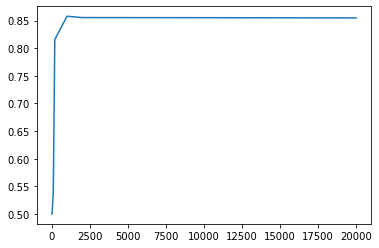

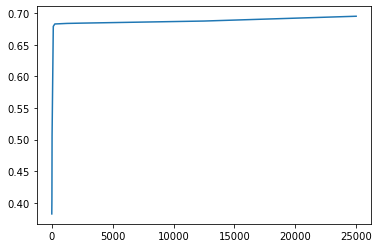

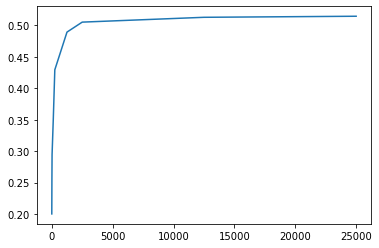

In [3]:
with open('results_test.pkl','rb') as f:
    results = pickle.load(f)

for n_classes in [2,3,5]:
    df_test = ut.load_data(DATA_PATH,'test',nclasses=n_classes).loc[:,['review_content','review_rate']]
    N_samples_tot = len(df_test)
    N_samples = []
    accuracies = []
    for frac, scores in results[n_classes].items():
        N_samples.append(int(frac * N_samples_tot))
        accuracies.append(scores['acc'])

    fig, ax = plt.subplots()
    ax.plot(N_samples,accuracies)
    #ax.set_xscale('log')

In [ ]:
results